In [1]:
import donkeycar as dk
import keras
import os
import numpy as np
import pandas as pd
from donkeycar import utils
from PIL import Image
from donkeycar.tools.fisheye_undistort import undistort

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

Using TensorFlow backend.


In [3]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    img_in = []
    angle_out = []
    throttle_out = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        img_in.append(rec['cam/image_array'])
        angle_out.append(rec['user/angle'])
        throttle_out.append(rec['user/throttle'])
    return (np.array(img_in), np.array(angle_out), np.array(throttle_out))

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    datasets = [dataset_from_tub(p, limit=-1) for p in tub_paths]
    img_in = [ds[0] for ds in datasets]
    angle_out = [ds[1] for ds in datasets]
    throttle_out = [ds[2] for ds in datasets]
    return (np.concatenate(img_in), np.concatenate(angle_out), np.concatenate(throttle_out))

def bin_angle_out(angle_out):
    return np.array([dk.utils.linear_bin(o) for o in angle_out])

def output_pair_cat(model, dataset):
    img_in, angle_out, throttle_out = dataset
    angle_binned, throttle = model.predict(img_in)
    predicted = dk.utils.unbin_Y(angle_binned)
    return (predicted, angle_out)

def output_pair_lin(model, dataset):
    img_in, angle_out, throttle_out = dataset
    predicted, throttle = model.predict(img_in)
    return (predicted, angle_out)

def undistort_dataset(dataset):
    return (np.asarray([undistort(img, balance=0.6) for img in dataset[0]]), dataset[1], dataset[2])

In [4]:
dataset = dataset_from_tub("../../donkeycar/d2/data.ws.test/tub_1_17-09-23", limit=-1)
img = dataset[0][100]

Tub does exist


`ws.cls.pruned.0.7022` was one of the best models trained from *raw images*.

I evaluate how well a model performs by visually asses how the prediction matches the actual;

As well as to caculate the average of the diffs between predicated steering angle and actual steering angle

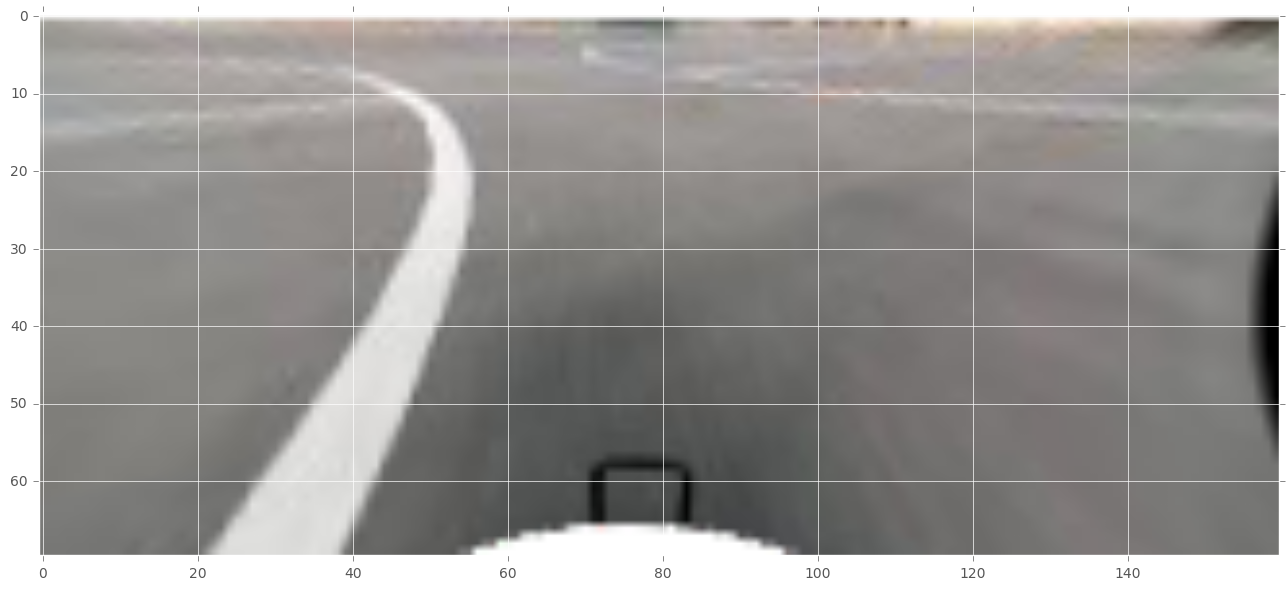

In [9]:
plt.figure()

plt.imshow(img[9:79,:,:])

Tub does exist
Average steering error: 0.04882348096602526


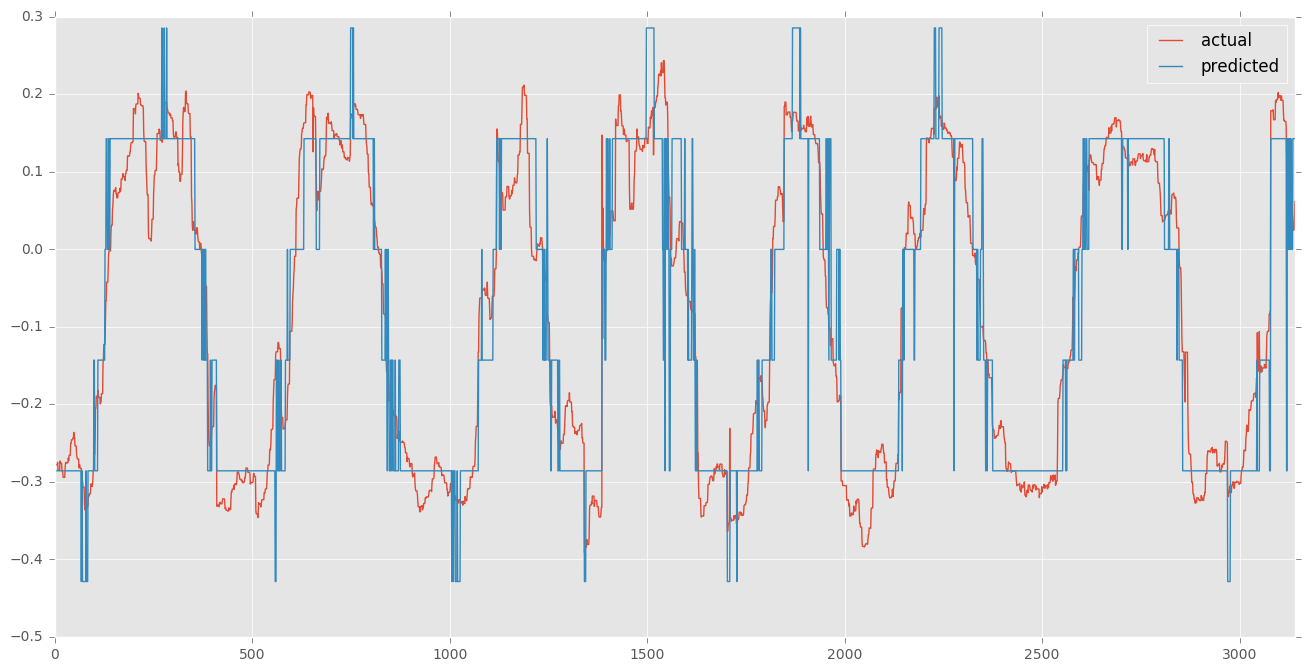

In [15]:
model = keras.models.load_model('../../donkeycar/d2/models/ws.nb.cls.newundist')
dataset = dataset_from_tub("../../donkeycar/d2/data.ws.test/tub_1_17-09-23", limit=-1)
# dataset = dataset_from_all_tubs("../../donkeycar/d2/data.ws.test")
predicted, actual = output_pair_cat(model, dataset)
df = pd.DataFrame(dict(predicted=predicted, actual=actual))
# using rolling average because the noises are smoothened by the inertia of the car
# df = df.rolling(5, win_type='triang').mean()
df.plot()
print("Average steering error: " + str(np.absolute(df['actual'] - df['predicted']).mean()))

`ws.cls.nb.undistort.0.79` is a model trained from the same data set but after *un-distorting the images*.

Visually the predicted steering angles matches actual ones better than the previous model.

The average steering error is 20% lower too!

*Note: `tub_1_17-09-23` was not part of training data (not even in validation data).*

Tub does exist
Tub does exist
Tub does exist
Average steering error: 0.06235607808645992


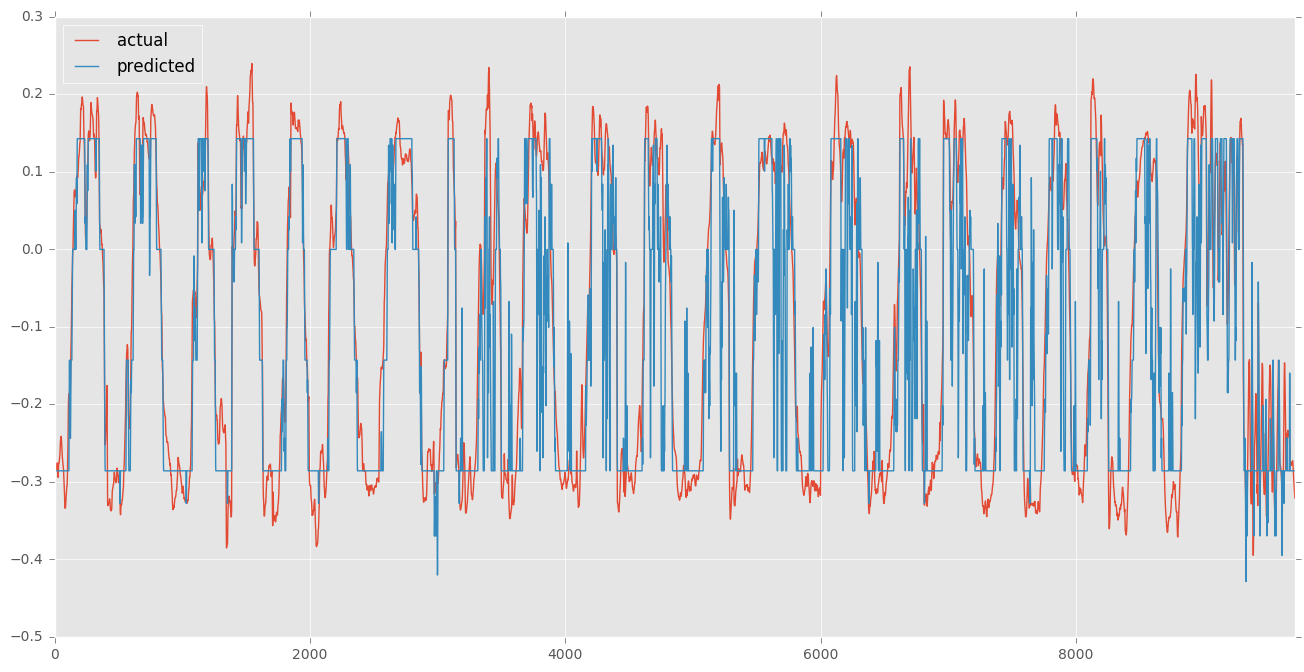

In [21]:
model = keras.models.load_model('../../donkeycar/d2/models/ws.cls.nb.undistort.0.79')
# dataset = dataset_from_tub("../../donkeycar/d2/data.ws.test/tub_1_17-09-23", limit=-1)
dataset = dataset_from_all_tubs("../../donkeycar/d2/data.ws.test")
predicted, actual = output_pair_cat(model, undistort_dataset(dataset))
df = pd.DataFrame(dict(predicted=predicted, actual=actual))
# using rolling average because the noises are smoothened by the inertia of the car
df = df.rolling(5, win_type='triang').mean()
df.plot()
print("Average steering error: " + str(np.absolute(df['actual'] - df['predicted']).mean()))

The same goes to regression models.

`ws.3fc_l1.pruned.0.048` is one of the best regression models I have trained using *raw images*

Tub does exist
Average steering error: 0.045006861370408914


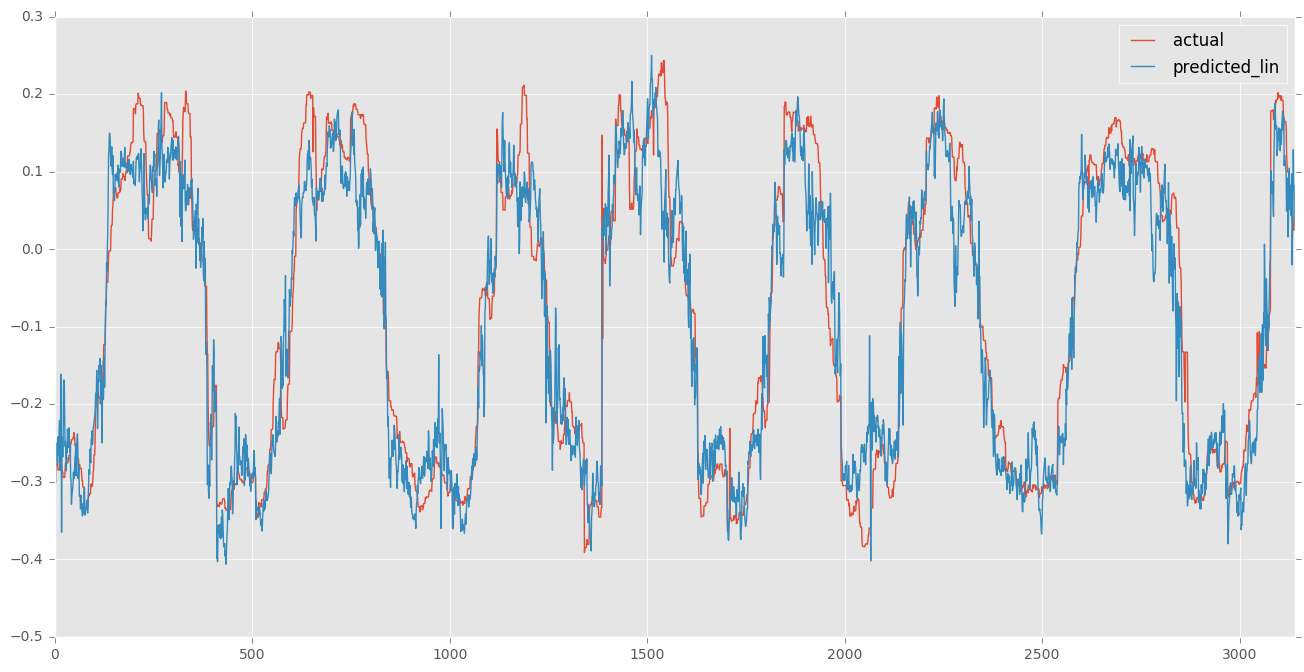

In [14]:
# dataset = dataset_from_all_tubs("../../donkeycar/d2/data.ws.test")
dataset = dataset_from_tub("../../donkeycar/d2/data.ws.test/tub_1_17-09-23", limit=-1)
model = keras.models.load_model('../../donkeycar/d2/models/ws.nb.3fc_l1.newundist.0.071')

predicted_lin, actual = output_pair_lin(model, dataset)
df = pd.DataFrame(dict(predicted_lin=predicted_lin[:,0], actual=actual))
# df = df.rolling(5, win_type='triang').mean()
df.plot()
print("Average steering error: " + str(np.absolute(df['actual'] - df['predicted_lin']).mean()))

`ws.3fc_l2.undistort.0.003` is a regression model trained using *un-distorted images*. From the graph and averge prediction error, there is a 40% improvement from the previous model!

Tub does exist
Tub does exist
Tub does exist
Average steering error: 0.07786449325302165


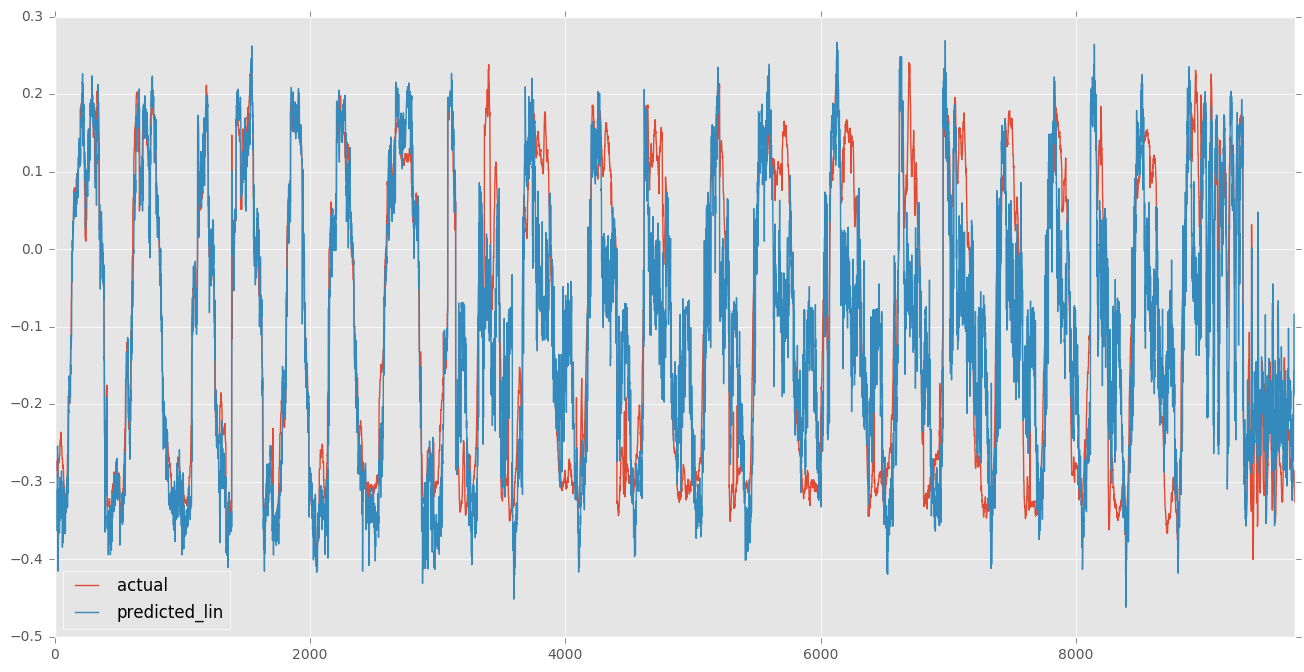

In [18]:
dataset = dataset_from_all_tubs("../../donkeycar/d2/data.ws.test")
# dataset = dataset_from_tub("../../donkeycar/d2/data.ws.test/tub_1_17-09-23", limit=-1)
model = keras.models.load_model('../../donkeycar/d2/models/ws.nb.3fc_l1.undistort.0.06')

predicted_lin, actual = output_pair_lin(model, undistort_dataset(dataset))
df = pd.DataFrame(dict(predicted_lin=predicted_lin[:,0], actual=actual))
# df = df.rolling(5, win_type='triang').mean()
df.plot()

print("Average steering error: " + str(np.absolute(df['actual'] - df['predicted_lin']).mean()))

In [23]:
dataset = dataset_from_tub("../../donkeycar/d2/data/tub_1_17-10-01", limit=-1)
img_in = dataset[0][-1]
img_in1 = dataset[0][200]
np.absolute(img_in.astype('float') - img_in1.astype('float')).astype('uint8')

Tub does exist


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[2, 0, 0],
        [2, 0, 0],
        [2, 0, 0],
        ..., 
        [2, 1, 1],
        [2, 1, 1],
        [1, 0, 0]],

       [[2, 0, 0],
        [2, 0, 0],
        [2, 0, 0],
        ..., 
        [2, 1, 1],
        [2, 1, 1],
        [2, 1, 1]],

       [[2, 0, 0],
        [2, 0, 0],
        [2, 0, 0],
        ..., 
        [2, 1, 1],
        [2, 1, 1],
        [2, 1, 1]]], dtype=uint8)